# FP20 Magnetooptical trap

Jeremy Gusti

Juan Provencio

30.10.2023

## General

In [1]:
# Packages
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline
import numpy as np
import os
import re
from numpy import exp, sqrt, log, pi, arcsin, sin
from scipy.optimize import curve_fit 
from scipy.stats import chi2
from scipy.special import erf
from glob import glob
from astropy.io import fits
from astropy.visualization import simple_norm
import matplotlib.patches as mpatches
import statistics as st
import pandas as pd
from scipy.signal import find_peaks
from iminuit import Minuit
from matplotlib import rcParams

In [2]:
# Commands
def fehler(name, G, sig_G, G_lit, sig_G_lit, r = 2, r_lit = 5):
    print('--------------------------------')
    print(name)
    a = 'Relative difference:'
    b = 'Rel. error (comparison): '
    c = 'Absolute differennce:'
    d = 'Sigma deviation:'
    
    print('Measurements: '.ljust(len(b)), np.round(G, r))
    print('+/-'.rjust(len(b)), np.round(sig_G, r))
    print('Comparison: '.ljust(len(b)), np.round(G_lit, r_lit))
    print('+/-'.rjust(len(b)), np.round(sig_G_lit, r_lit))
    print('\n')
    print(a.ljust(len(b)), 100 * abs(1 - G / G_lit), ' %')
#    print(b.ljust(len(b)), sig_G_lit / G_lit * 100)
    print(c.ljust(len(b)), G - G_lit)
    print(d.ljust(len(b)), np.abs(G - G_lit) / sqrt(sig_G ** 2 
                                                    + sig_G_lit ** 2),'\n')
    
    
def fehler_small(name, G, sig_G):
    print(name)
    print('Relativer Fehler: ', sig_G / G * 100)
    

def result(name, G, sig_G, units, r = 2):

    b = name
    
    print(b + ': ', np.round(G, r))
    print('+/-'.rjust(len(b) + 2), np.round(sig_G, r), units)

'''def result(name, G, sig_G, komma, einheit):
    print(name + ' =', np.round(G, komma), '+/-', np.round(sig_G, komma
                                                          ), einheit)'''
    

def fitparameter(name, G, sig_G, komma, einheit):
    return name + ' =' + str(np.round(G, komma)
                            ) + '$\pm$' + str(np.round(sig_G, komma)
                                             ) + einheit

def chi_sq(test_func, x_val, y_val, sig_y_val, popt, number):
    chi2_ = np.sum((test_func(x_val, *popt) - y_val) ** 2 
                   / sig_y_val ** 2)
    dof = len(y_val) - number
    chi2_red = chi2_ / dof

    print('chi2 =', chi2_)
    print('chi2_red =',chi2_red)

    prob = np.round(1 - chi2.cdf(chi2_,dof), 2) * 100 
    print('Probability =', prob, '%\n')

    
# box design
props = dict(boxstyle = 'round', facecolor = 'white', alpha = 0.5)


# make a box with parameters in plot
def textstrer(title, params, err_params, units, labels, a, b, r = 2, 
              fonts = 14):
    textstr = np.array([title + '\n'])
    
    for i in range(len(params)):
        textstr = np.append(textstr, 
                            '${} = {} \pm {}\ {}$' .
                            format(labels[i],
                                   round(params[i], r),
                                   round(err_params[i], r),
                                   units[i]
                                  )) # Create a textstring w/ all parameters
    plt.text(a, b, ''.join(map(lambda x: x[:] + '\n', textstr)),
            verticalalignment = 'top', fontsize = fonts, bbox = props)

In [3]:
# Default plot style
rcParams['axes.linewidth'] = 2
rcParams['axes.edgecolor'] = 'grey'
rcParams['axes.grid'] = True
rcParams['grid.linestyle'] = (5,10)

rcParams['figure.figsize'] = (12, 7)
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 14
rcParams['legend.fontsize'] = 14
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14

## Data analysis

### 1. Doppler free spectroscopy

We recorded the $^{87}$Rb $F=2 \to F'$, $^{85}$Rb $F = 3 \to F'$, $^{85}$Rb $F = 2 \to F'$, and $^{87}$Rb $F = 1 \to F'$ with and without the Doppler free spectroscopy method. The full spectrum and each valley individually were measured.

#### 1.1 Multiplet separation

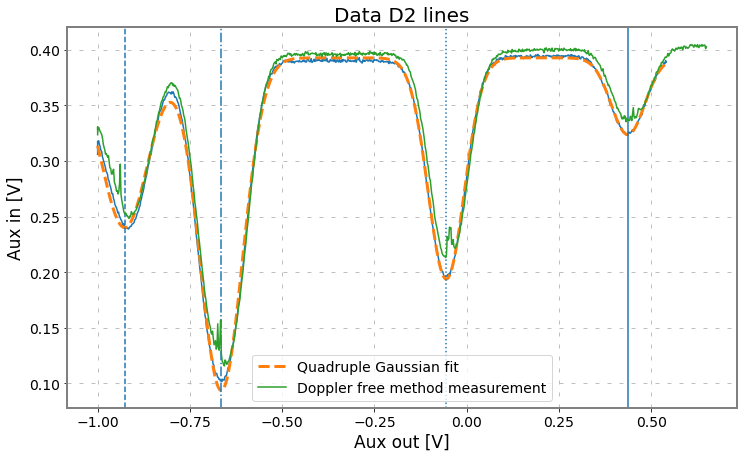

In [4]:
# Read data
def tolino(file):
    data = pd.read_csv(file, sep = '\t')
    data_lines = [data['Aux out [V]'].to_numpy(),
                 data['Aux in [V]'].to_numpy()]
    
    return data_lines

data_D2_DB = tolino('data/1.2/1.2 - D2 lines Doppler broadened.txt')
data_D2_DF = tolino('data/1.2/1.2 - D2 lines Doppler free.txt')

# Fits
def gaussian(x, a, b, c, d):
    return a * exp( - (x - b) ** 2 / (2 * c ** 2) ) + d

def quad_gaussian(x, a1, b1, c1, a2, b2, c2, a3, b3, c3, a4, b4, c4, d):
    return (gaussian(x, a1, b1, c1, d = 0) 
            + gaussian(x, a2, b2, c2, d = 0) 
            + gaussian(x, a3, b3, c3, d = 0) 
            + gaussian(x, a4, b4, c4, d))

# Create command to automatically plot the spectrum of our data
def plotter(title, data):
    plt.figure(figsize = (12, 7))
    plt.title(title, size = 20)
    plt.xlabel('Aux out [V]', size = 17)
    plt.xticks(size = 14)
    plt.ylabel('Aux in [V]', size = 17)
    plt.yticks(size = 14)
    plt.plot(data[0], data[1])

def fitter(title, data, function, p_0, label):
    popt, pcov = curve_fit(function, data[0], data[1], p0 = p_0)
    
    plotter(title, data)

    x_lin = np.linspace(data[0][0], data[0][-1], 1000)
    plt.plot(x_lin, function(x_lin, *popt), label = label, linewidth = 3, 
             ls = '--')
    
    plt.legend(loc = 'best')
    
    return popt, pcov

p0 = [-0.1, -0.85, 0.1, -0.3, -0.7, 0.1, -0.2, -0.1, 0.1, -0.1, 0.5, 0.1, 0.4]
popt_Rb, pcov_Rb = fitter('Data D2 lines', data_D2_DB, quad_gaussian, p0, 
                    'Quadruple Gaussian fit')

#labels = ['$^{87}$Rb, F = 2', '$^{85}$Rb, F = 3', '$^{85}$Rb, F = 2', '$^{87}$Rb, F = 1']
linestyles = ['--', '-.', ':', '-']
for i in range(len(popt_Rb[1::3])):
    plt.axvline(popt_Rb[1::3][i], ls = linestyles[i])#, label = labels[i])

plt.plot(data_D2_DF[0], data_D2_DF[1], label = 'Doppler free method measurement')
plt.legend(loc = 'best')
plt.savefig('diagrams/Data_D2_lines.png')
plt.show()


We calibrate the horizontal axis by measuring the distance between the $F=1,2$ states for the $^{87}$Rb ground state $5 S_{1/2}$ and the energy difference per [IOPScience](https://iopscience.iop.org/article/10.1209/epl/i1999-00203-9). As the error for the position of the peaks we will use the 1$\sigma$ separation from the mean given by the parameter $c$ in our definition of the Gaussian.

In [5]:
Delta_x = abs(popt_Rb[1::3][0] - popt_Rb[1::3][-1]) # meas difference F = 1,2 
err_Delta_x = sqrt(popt_Rb[2::3][0] ** 2 + popt_Rb[2::3][-1] ** 2) 
Delta_f = 6.83 # GHz, theo difference (rounded to arbitrary significant digits)

m_87 = Delta_f / Delta_x
err_m_87 = Delta_f / (Delta_x ** 2) * err_Delta_x

result('Calibration factor', m_87, err_m_87, '[GHz / V]')

Calibration factor:  5.01
                 +/- 0.29 [GHz / V]


Additionally, we can perform the same thing for the two available peaks from the $^{85}$Rb isotope.

In [6]:
Delta_x_85 = abs(popt_Rb[1::3][1] - popt_Rb[1::3][2]) # meas difference F = 1,2 
err_Delta_x_85 = sqrt(popt_Rb[2::3][1] ** 2 + popt_Rb[2::3][2] ** 2) 
Delta_f_85 = 3.04 # GHz, theo difference (rounded to arbitrary significant digits)

m_85 = Delta_f_85 / Delta_x_85
err_m_85 = Delta_f_85 / (Delta_x_85 ** 2) * err_Delta_x_85

result('Calibration factor (85)', m_85, err_m_85, '[GHz / V]')

Calibration factor (85):  4.99
                      +/- 0.62 [GHz / V]


In [7]:
fehler('Calibration factors', m_87, err_m_87, m_85, err_m_85, r = 2, r_lit = 2)

--------------------------------
Calibration factors
Measurements:             5.01
                      +/- 0.29
Comparison:               4.99
                      +/- 0.62


Relative difference:      0.42601628663656577  %
Absolute differennce:     0.021247003694569777
Sigma deviation:          0.031176646054237683 



We can see that both values are in great accordance to each other, but that the measurement with the peaks further apart is significantly more accurate, by a factor of more than 2.

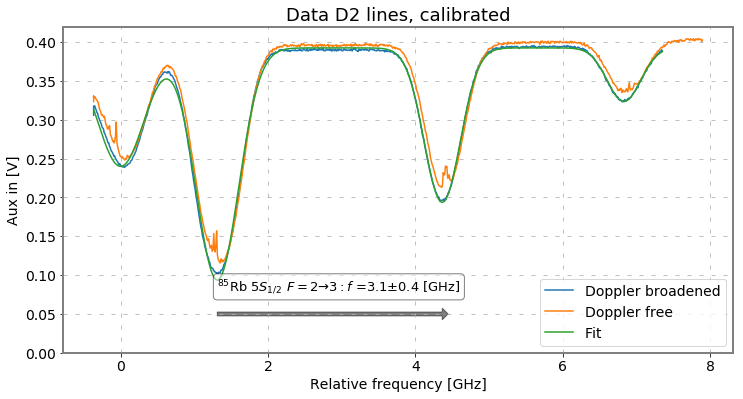

In [8]:
# Read data
data_D2_DB_cal = [(data_D2_DB[0] 
                   - popt_Rb[1::3][0]) * m_87, 
                  data_D2_DB[1]]

data_D2_DF_cal = [(data_D2_DF[0]
                   - popt_Rb[1::3][0]) * m_87, 
                   data_D2_DF[1]]

plt.figure(figsize = (12, 6))
plt.title('Data D2 lines, calibrated')

plt.plot(data_D2_DB_cal[0], data_D2_DB_cal[1], label = 'Doppler broadened')
plt.plot(data_D2_DF_cal[0], data_D2_DF_cal[1], label = 'Doppler free')

a_Rb_cal = popt_Rb[0::3][:-1]
b_Rb_cal = (popt_Rb[1::3] - popt_Rb[1::3][0]) * m_87
c_Rb_cal = (popt_Rb[2::3]) * m_87
popt_Rb_cal = [a_Rb_cal[0], b_Rb_cal[0], c_Rb_cal[0], 
               a_Rb_cal[1], b_Rb_cal[1], c_Rb_cal[1], 
               a_Rb_cal[2], b_Rb_cal[2], c_Rb_cal[2], 
               a_Rb_cal[3], b_Rb_cal[3], c_Rb_cal[3], popt_Rb[-1]]

f_85_23 = Delta_x_85 * m_87
err_f_85_23 = err_Delta_x_85 * m_87

f_85_23_lit = 3.0357324390
 
f_lin = np.linspace(data_D2_DB_cal[0][0], data_D2_DB_cal[0][-1], 1000)
plt.plot(f_lin, quad_gaussian(f_lin, *popt_Rb_cal), label = 'Fit')

#plt.axvline(b_Rb_cal[1], ls = '-.', color = 'tomato', 
 #           label = '$^{85}$Rb $5S_{1/2}\, F = 2$')
#plt.axvline(b_Rb_cal[2], ls = '-.', color = 'olive', 
 #           label = '$^{85}$Rb $5S_{1/2}\, F = 3$')
    
plt.arrow(b_Rb_cal[1], 0.05, b_Rb_cal[2] - b_Rb_cal[1], 0, 
          width = 0.005, alpha = 0.5, color = 'black', head_length = 0.08)
plt.text(b_Rb_cal[1], 0.08, fitparameter('$^{85}$Rb $5S_{1/2}\ F=2\\to3: f$',
                                        f_85_23, err_f_85_23, 1, ' [GHz]'),
        bbox = props, fontsize = 13)

plt.xlabel('Relative frequency [GHz]')
plt.ylabel('Aux in [V]')
plt.ylim(0, 0.42)

plt.legend(loc = 'best')
plt.savefig('diagrams/Data_D2_lines_cal.png')

In [9]:
fehler('85Rb F = 2 -> 3 transition', f_85_23, err_f_85_23, f_85_23_lit, 0)

--------------------------------
85Rb F = 2 -> 3 transition
Measurements:             3.05
                      +/- 0.38
Comparison:               3.03573
                      +/- 0


Relative difference:      0.5671928096345757  %
Absolute differennce:     0.01721845611375228
Sigma deviation:          0.04552994252541672 



#### 1.2 Natural transition line width and hyperfine splitting

Now we perform a similar analysis on the following transitions:

$^{87}$Rb $F=2 \to F'$, 

$^{85}$Rb $F = 3 \to F'$, 

$^{85}$Rb $F = 2 \to F'$, and 

$^{87}$Rb $F = 1 \to F'$.

We imaged these up close and we'll fit individual Gaussian functions to the Doppler broadened spectra. On top of the real absorption lines, we'll fit a Lorentzian curve.

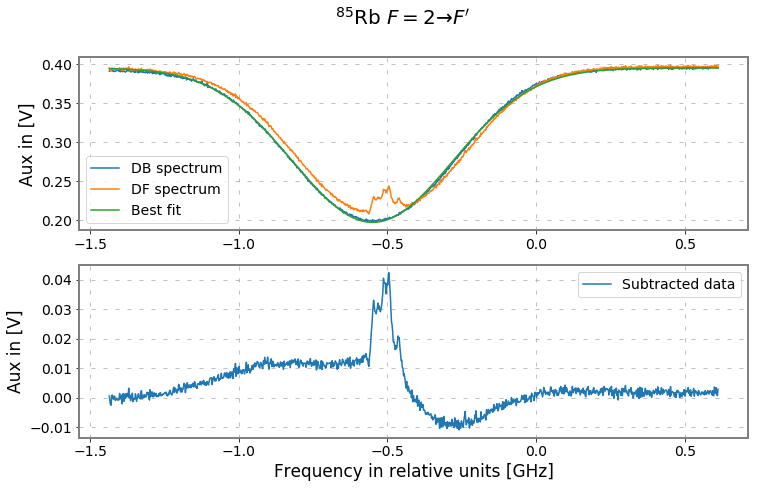

In [10]:
# Data
def reader_plotter(name, file_DF, file_DB, p_0):
    # Read the data
    data_DF = tolino(file_DF) 
    data_DF[0] = data_DF[0] * m_87 # Use calibration
    data_DB = tolino(file_DB)
    data_DB[0] = data_DB[0] * m_87
    # Plot the data
    fig, (ax1, ax2) = plt.subplots(2, figsize = (12, 7))
    fig.suptitle(name, fontsize = 20)
    
    ax1.plot(data_DB[0], data_DB[1], label = 'DB spectrum')
    ax1.plot(data_DF[0], data_DF[1], label = 'DF spectrum')
    # Use the broadened data to perform a fit
    popt, pcov = curve_fit(gaussian, data_DB[0], data_DB[1], p0 = p_0)
    f_lin = np.linspace(data_DB[0][0], data_DB[0][-1], len(data_DB[0]))
    ax1.plot(f_lin, gaussian(f_lin, *popt), label = 'Best fit')
    ax1.set_ylabel('Aux in [V]', fontsize = 17)
    
    ax1.legend(loc = 'best')
    # Subtract the fit from the measurement
    data_sub = data_DF[1] - gaussian(data_DF[0], *popt)
    ax2.plot(data_DF[0], data_sub, label = 'Subtracted data')
    ax2.set_xlabel('Frequency in relative units [GHz]', fontsize = 17)
    ax2.set_ylabel('Aux in [V]', fontsize = 17)
    
    ax2.legend(loc = 'best')
    
    return fig, data_DF, data_DB, data_sub

# 85Rb F = 2 to F'
fig, DF_85F2, DB_85F2, sub_85F2 = reader_plotter("$^{85}$Rb $F = 2 \\to F'$ ", 
                           'data/1.2/1.2 - 85 F2 Doppler free.txt',
                           'data/1.2/1.2 - 85 F2 Doppler broadened.txt',
                           p_0 = [-0.25, -0.5, 0.5, 0.4])




fig.savefig('diagrams/ex85RbF2.png')

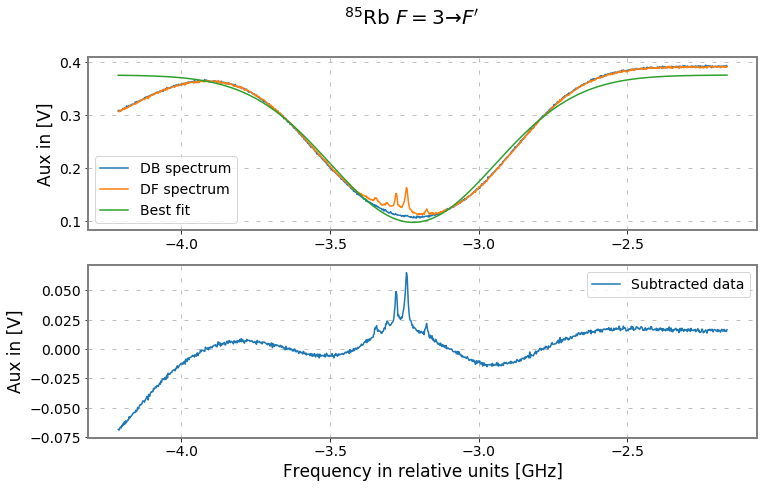

In [11]:
# 85 Rb F = 3 to F'
fig, DF_85F3, DB_85F3, sub_85F3 = reader_plotter("$^{85}$Rb $F = 3 \\to F'$ ", 
                           'data/1.2/1.2 - 85 F3 Doppler free.txt',
                           'data/1.2/1.2 - 85 F3 Doppler broadened.txt',
                           p_0 = [-0.25, -3.25, 0.5, 0.4])


fig.savefig('diagrams/ex85RbF3.png')

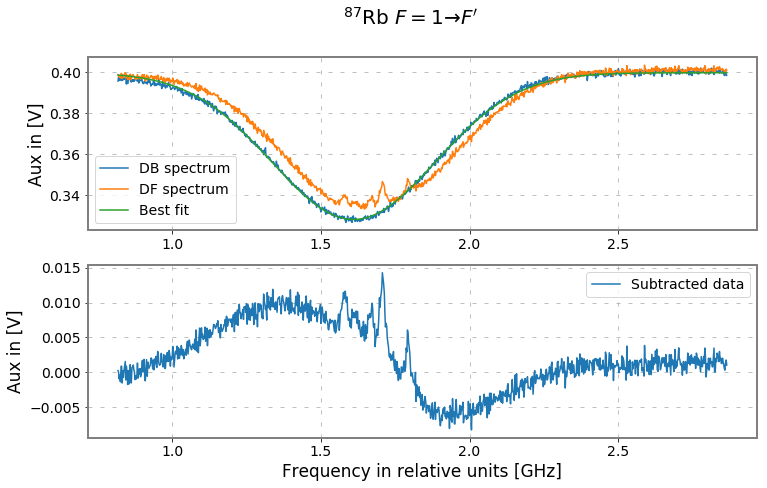

In [12]:
# 87 Rb F = 1 to F'
fig, DF_87F1, DB_87F1, sub_87F1 = reader_plotter("$^{87}$Rb $F = 1 \\to F'$ ", 
               'data/1.2/1.2 - 87 F1 Doppler free.txt',
               'data/1.2/1.2 - 87 F1 Doppler broadened.txt',
               p_0 = [-0.1, 0, 0.5, 0.4])


fig.savefig('diagrams/ex87RbF1.png')

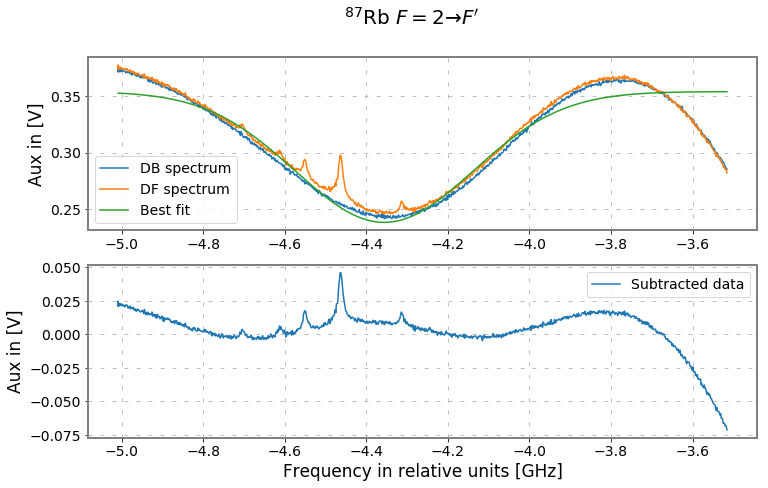

In [13]:
# 87 Rb F = 2 to F'
fig, DF_87F2, DB_87F2, sub_87F2 = reader_plotter("$^{87}$Rb $F = 2 \\to F'$ ", 
               'data/1.2/1.2 - 87 F2 Doppler free.txt',
               'data/1.2/1.2 - 87 F2 Doppler broadened.txt',
               p_0 = [-0.1, -3.6, 0.5, 0.4])


fig.savefig('diagrams/ex87RbF2.png')

Now we'll take a closer look at the area where the absorption peaks lie. We will first figure out which peak corresponds to which transition and with two good peaks determine the required calibration factor. We will want to compare all calibration factors, and by all I suppose it to mean one for every plot and not all 3 for all 4 plots. 

This is a bit tricky, because we need to identify the crossover peaks as well and eliminate them. We can use Figure 10 in the script as comparison to do this by eye.

<a id='RB85F2'></a>

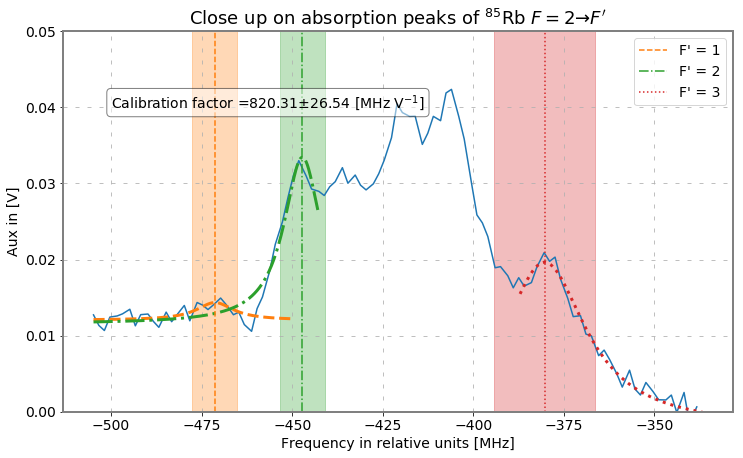

In [14]:
# Lorentzian
def lorentzian(nu, a, nu0, Gamma, d):
    return a / (1 + 4 * (nu - nu0) ** 2 / Gamma ** 2) + d


# 85 F = 2
plt.title("Close up on absorption peaks of $^{85}$Rb $F = 2 \\to F'$ ")
plt.xlabel('Frequency in relative units [MHz]')
plt.ylabel('Aux in [V]')

''' We plot the data in a convenient interval and then manually find the peaks 
we're interested in. To avoid the extra plots and clutter, we will first 
determine the calibration factor and then move up the code so that it only
shows the finished result '''


a = 400
b = 500

a1 = 420
a2 = 434
a3 = 475


# Calibration of horizontal axis
Delta_x_85F2_13 = DF_85F2[0][a3] - DF_85F2[0][a1]
err_Delta_x_85F2_13 = np.abs(DF_85F2[0][0] - DF_85F2[0][2]) # Estimated error

Delta_f_85F2_13 = 63.401 + 29.372 # MHz, 1->3 frequency separation
err_Delta_f_85F2_13 = sqrt(0.061 ** 2 + 0.09 ** 2)

m_85F2_13 = Delta_f_85F2_13 / Delta_x_85F2_13
err_m_85F2_13 = sqrt( (err_Delta_f_85F2_13 / Delta_x_85F2_13) ** 2 
                     + (Delta_f_85F2_13 * err_Delta_x_85F2_13 
                        / (Delta_x_85F2_13) ** 2) ** 2 )


plt.text(-500, 0.04, fitparameter('Calibration factor', 
                                  m_85F2_13, err_m_85F2_13, 2, ' [MHz V$^{-1}$]'),
        bbox = props, fontsize = 14)

new_DF_85F2 = DF_85F2[0] * m_85F2_13

# Plot
plt.plot(new_DF_85F2[a:b], sub_85F2[a:b])

# Fit
f_lin = np.linspace(new_DF_85F2[a], new_DF_85F2[b], 1000)
popt_85F2_1, pcov_85F2_1 = curve_fit(lorentzian, new_DF_85F2[a1-20:a1+4],
                                    sub_85F2[a1-20:a1+4],
                                    p0 = [0.002, -474, 70, 0.01])
popt_85F2_2, pcov_85F2_2 = curve_fit(lorentzian, new_DF_85F2[a2-20:a2+4],
                                    sub_85F2[a2-20:a2+4],
                                    p0 = [0.023, -449, 10, 0.01])
popt_85F2_3, pcov_85F2_3 = curve_fit(lorentzian, new_DF_85F2[a3-4:a3+30], 
                                     sub_85F2[a3-4:a3+30],
                                    p0 = [0.02, -379, 20, 0.001])


plt.ylim(0, 0.05)
#plt.plot(f_lin, lorentzian(f_lin, 0.023, -449, 10, 0.01), color = 'C2')
plt.plot(f_lin[:330], lorentzian(f_lin[:330], *popt_85F2_1), color = 'C1', 
         ls = '--', lw = 3)
plt.plot(f_lin[:370], lorentzian(f_lin[:370], *popt_85F2_2), color = 'C2', 
         ls = '-.', lw = 3)
plt.plot(f_lin[700:], lorentzian(f_lin[700:], *popt_85F2_3), color = 'C3', 
         ls = ':', lw = 3)

# Some lines and stuff
plt.axvline(popt_85F2_1[1], ls = '--', color = 'C1', label = "F' = 1")
plt.axvline(popt_85F2_2[1], ls = '-.', color = 'C2', label = "F' = 2")
plt.axvline(popt_85F2_3[1], ls = ':', color = 'C3', label = "F' = 3")
plt.axvspan(popt_85F2_1[1] - popt_85F2_1[2] / 2, 
            popt_85F2_1[1] + popt_85F2_1[2] / 2, 
            color = 'C1', alpha = 0.3)
plt.axvspan(popt_85F2_2[1] - popt_85F2_2[2] / 2, 
            popt_85F2_2[1] + popt_85F2_2[2] / 2, 
            color = 'C2', alpha = 0.3)
plt.axvspan(popt_85F2_3[1] - popt_85F2_3[2] / 2, 
            popt_85F2_3[1] + popt_85F2_3[2] / 2, 
            color = 'C3', alpha = 0.3)

plt.legend(loc = 'best')
plt.savefig('diagrams/85F2_absorption_peaks.png')

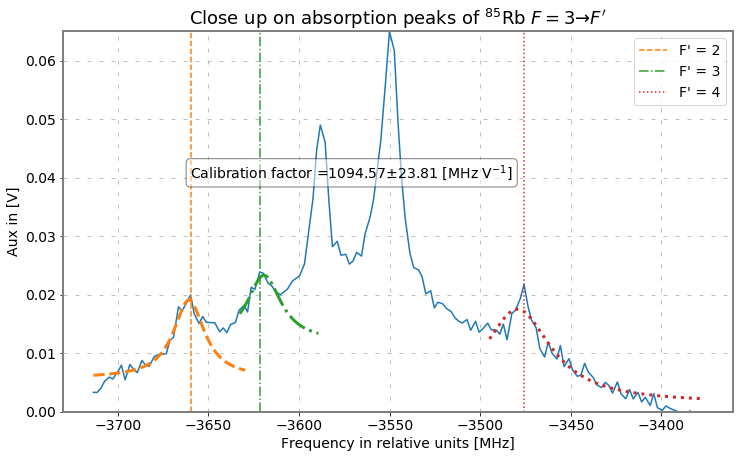

In [15]:
# 85 F = 3
plt.title("Close up on absorption peaks of $^{85}$Rb $F = 3 \\to F'$ ")
plt.xlabel('Frequency in relative units [MHz]')
plt.ylabel('Aux in [V]')

''' We plot the data in a convenient interval and then manually find the peaks 
we're interested in. To avoid the extra plots and clutter, we will first 
determine the calibration factor and then move up the code so that it only
shows the finished result '''

a = 400
b = 550

a1 = 424
a2 = 441
a3 = 506


# Calibration of horizontal axis
Delta_x_85F3_24 = DF_85F3[0][a3] - DF_85F3[0][a1]
err_Delta_x_85F3_24 = np.abs(DF_85F3[0][0] - DF_85F3[0][2]) # Estimated error

Delta_f_85F3_24 = 63.401 + 120.640 # MHz, 2->4 frequency separation
err_Delta_f_85F3_24 = sqrt(0.061 ** 2 + 0.06 ** 2)

m_85F3_24 = Delta_f_85F3_24 / Delta_x_85F3_24
err_m_85F3_24 = sqrt( (err_Delta_f_85F3_24 / Delta_x_85F3_24) ** 2 
                     + (Delta_f_85F3_24 * err_Delta_x_85F3_24 
                        / (Delta_x_85F3_24) ** 2) ** 2 )

plt.text(-3660, 0.04, fitparameter('Calibration factor', 
                                  m_85F3_24, err_m_85F3_24, 2, ' [MHz V$^{-1}$]'),
        bbox = props, fontsize = 14)

new_DF_85F3 = DF_85F3[0] * m_85F3_24

# Plot
plt.plot(new_DF_85F3[a:b], sub_85F3[a:b])


plt.axvline(new_DF_85F3[a1], ls = '--', color = 'C1', label = "F' = 2")
plt.axvline(new_DF_85F3[a2], ls = '-.', color = 'C2', label = "F' = 3")
plt.axvline(new_DF_85F3[a3], ls = ':', color = 'C3', label = "F' = 4")



# Fit
f_lin = np.linspace(new_DF_85F3[a], new_DF_85F3[b], 1000)

popt_85F3_2, pcov_85F3_2 = curve_fit(lorentzian, new_DF_85F3[a1-20:a1+4],
                                    sub_85F3[a1-20:a1+4],
                                    p0 = [0.015, -3621, 20, 0.005])
popt_85F3_3, pcov_85F3_3 = curve_fit(lorentzian, new_DF_85F3[a2-6:a2+6],
                                    sub_85F3[a2-6:a2+6],
                                    p0 = [0.018, -3580, 30, 0.005])
popt_85F3_4, pcov_85F3_4 = curve_fit(lorentzian, new_DF_85F3[a3-9:a3+31], 
                                     sub_85F3[a3-9:a3+31],
                                    p0 = [0.018, -3475, 20, 0.005])

plt.ylim(0, 0.065)

#plt.plot(f_lin, lorentzian(f_lin, 0.018, -3438, 20, 0.005), color = 'C5')

plt.plot(f_lin[:250], lorentzian(f_lin[:250], *popt_85F3_2), 
         color = 'C1', ls = '--', lw = 3)
plt.plot(f_lin[240:370], lorentzian(f_lin[240:370], *popt_85F3_3), 
         color = 'C2', ls = '-.', lw = 3)
plt.plot(f_lin[650:], lorentzian(f_lin[650:], *popt_85F3_4), 
         color = 'C3', ls = ':', lw = 3)

plt.legend(loc = 'best')
plt.savefig('diagrams/85F3_absorption_peaks.png')

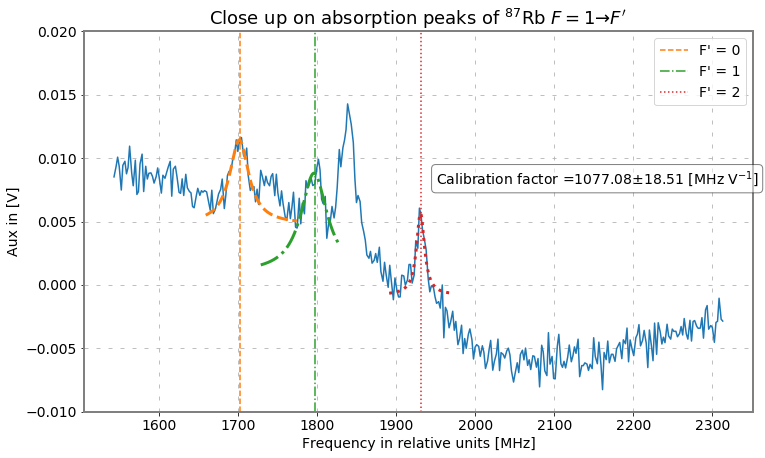

In [16]:
# 87 F = 1
plt.title("Close up on absorption peaks of $^{87}$Rb $F = 1 \\to F'$ ")
plt.xlabel('Frequency in relative units [MHz]')
plt.ylabel('Aux in [V]')

''' We plot the data in a convenient interval and then manually find the peaks 
we're interested in. To avoid the extra plots and clutter, we will first 
determine the calibration factor and then move up the code so that it only
shows the finished result '''

a = 300
b = 650

a1 = 372
a2 = 415
a3 = 476


# Calibration of horizontal axis
Delta_x_87F1_02 = DF_87F1[0][a3] - DF_87F1[0][a1]
err_Delta_x_87F1_02 = np.abs(DF_87F1[0][0] - DF_87F1[0][2]) # Estimated error

Delta_f_87F1_02 = 72.2180 + 156.9470 # MHz, 0->2 frequency separation
err_Delta_f_87F1_02 = sqrt(0.004 ** 2 + 0.007 ** 2)

m_87F1_02 = Delta_f_87F1_02 / Delta_x_87F1_02
err_m_87F1_02 = sqrt( (err_Delta_f_87F1_02 / Delta_x_87F1_02) ** 2 
                     + (Delta_f_87F1_02 * err_Delta_x_87F1_02 
                        / (Delta_x_87F1_02) ** 2) ** 2 )

plt.text(1950, 0.008, fitparameter('Calibration factor', 
                                  m_87F1_02, err_m_87F1_02, 2, 
                                   ' [MHz V$^{-1}$]'),
        bbox = props, fontsize = 14)

new_DF_87F1 = DF_87F1[0] * m_87F1_02

# Plot
plt.plot(new_DF_87F1[a:b], sub_87F1[a:b])


plt.axvline(new_DF_87F1[a1], ls = '--', color = 'C1', label = "F' = 0")

plt.axvline(new_DF_87F1[a2], ls = '-.', color = 'C2', label = "F' = 1")
plt.axvline(new_DF_87F1[a3], ls = ':', color = 'C3', label = "F' = 2")



# Fit
f_lin = np.linspace(new_DF_87F1[a], new_DF_87F1[b], 1000)

popt_87F1_0, pcov_87F1_0 = curve_fit(lorentzian, new_DF_87F1[a1-10:a1+10], 
                                     sub_87F1[a1-10:a1+10],
                                    p0 = [0.005, 1700, 30, 0.006])
popt_87F1_1, pcov_87F1_1 = curve_fit(lorentzian, new_DF_87F1[a2-10:a2+10],
                                    sub_87F1[a2-10:a2+10],
                                    p0 = [0.005, 1800, 30, 0.005])
popt_87F1_2, pcov_87F1_2 = curve_fit(lorentzian, new_DF_87F1[a3-10:a3+10],
                                    sub_87F1[a3-10:a3+10],
                                    p0 = [0.005, 1930, 10, 0.0005])



plt.ylim(-0.01, 0.02)

#plt.plot(f_lin, lorentzian(f_lin, 0.005, 1800, 30, 0.005), color = 'C5')

plt.plot(f_lin[150:300], lorentzian(f_lin[150:300], *popt_87F1_0), 
         color = 'C1', ls = '--', lw = 3)
plt.plot(f_lin[240:370], lorentzian(f_lin[240:370], *popt_87F1_1), 
         color = 'C2', ls = '-.', lw = 3)
plt.plot(f_lin[450:550], lorentzian(f_lin[450:550], *popt_87F1_2), 
         color = 'C3', ls = ':', lw = 3)



plt.legend(loc = 'best')
plt.savefig('diagrams/87F1_absorption_peaks.png')

plt.show()

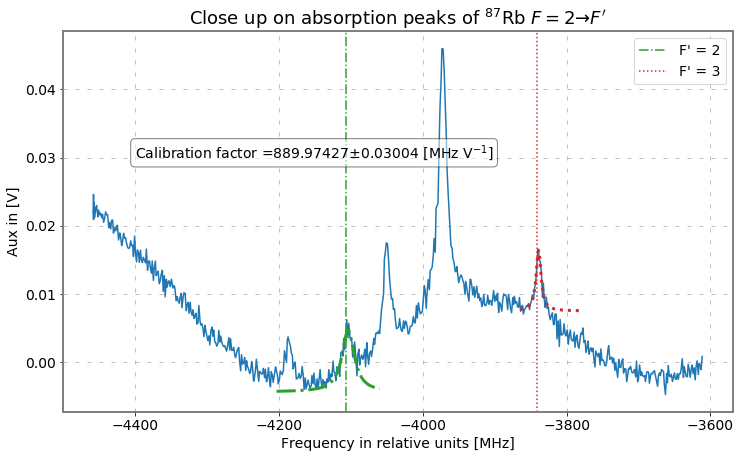

In [17]:
# 87 F = 2
plt.title("Close up on absorption peaks of $^{87}$Rb $F = 2 \\to F'$ ")
plt.xlabel('Frequency in relative units [MHz]')
plt.ylabel('Aux in [V]')

''' We plot the data in a convenient interval and then manually find the peaks 
we're interested in. To avoid the extra plots and clutter, we will first 
determine the calibration factor and then move up the code so that it only
shows the finished result '''

a = 0
b = 650

a1 = 232
a2 = 290
a3 = 483


# Calibration of horizontal axis
Delta_x_87F2_23 = DF_87F2[0][a3] - DF_87F2[0][a2]
err_Delta_x_87F2_23 = np.abs(DF_87F2[0][0] - DF_87F2[0][2]) # Estimated error

Delta_f_87F2_23 = 266.6500 # MHz, 0->2 frequency separation
err_Delta_f_87F2_23 = sqrt(0.009 ** 2)

m_87F2_23 = Delta_f_87F2_23 / Delta_x_87F2_23
err_m_87F2_23 = sqrt( (err_Delta_f_87F2_23 / Delta_x_87F2_23) ** 2 
                     + (Delta_f_87F2_23 * err_Delta_x_87F2_23 
                        / (Delta_x_87F2_23) ** 2) ** 2 )

plt.text(-4400, 0.03, fitparameter('Calibration factor', 
                                  m_87F2_23, err_m_87F2_23, 5, 
                                   ' [MHz V$^{-1}$]'),
        bbox = props, fontsize = 14)

new_DF_87F2 = DF_87F2[0] * m_87F2_23

# Plot
plt.plot(new_DF_87F2[a:b], sub_87F2[a:b])


#plt.axvline(new_DF_87F2[a1], ls = '--', color = 'C1', label = "F' = 1")
plt.axvline(new_DF_87F2[a2], ls = '-.', color = 'C2', label = "F' = 2")
plt.axvline(new_DF_87F2[a3], ls = ':', color = 'C3', label = "F' = 3")



# Fit
f_lin = np.linspace(new_DF_87F2[a], new_DF_87F2[b], 1000)


popt_87F2_2, pcov_87F2_2 = curve_fit(lorentzian, new_DF_87F2[a2-10:a2+10],
                                    sub_87F2[a2-10:a2+10],
                                    p0 = [0.01, -4105, 20, -0.003])

popt_87F2_3, pcov_87F2_3 = curve_fit(lorentzian, new_DF_87F2[a3-10:a3+10],
                                    sub_87F2[a3-10:a3+10],
                                    p0 = [0.013, -3840, 20, 0.003])




#plt.plot(f_lin, lorentzian(f_lin, 0.013, -3840, 20, 0.003), color = 'C5')


plt.plot(f_lin[300:470], lorentzian(f_lin[300:470], *popt_87F2_2), 
         color = 'C2', ls = '-.', lw = 3)
plt.plot(f_lin[700:800], lorentzian(f_lin[700:800], *popt_87F2_3), 
         color = 'C3', ls = ':', lw = 3)



plt.legend(loc = 'best')
plt.savefig('diagrams/87F2_absorption_peaks.png')

plt.show()

We now compare all calibration factors:

In [18]:
ms = np.array([m_85F2_13, m_85F3_24, m_87F1_02, m_87F2_23])
err_ms = np.array([err_m_85F2_13, err_m_85F3_24, err_m_87F1_02, err_m_87F2_23])
labels = np.array(['(85 Rb F = 2, 1 -> 3)', '(85 Rb F = 3, 2 -> 4)', 
                   '(87 Rb F = 1, 0 -> 2)', '(87 Rb F = 2, 2 -> 3)'])
for i in range(len(ms)):
    for j in range(len(ms)):
        if j > i:
            fehler('Calibration factors from ' 
                   + labels[i] + ' and ' + labels[j], 
                   ms[i], err_ms[i], ms[j], err_ms[j])

--------------------------------
Calibration factors from (85 Rb F = 2, 1 -> 3) and (85 Rb F = 3, 2 -> 4)
Measurements:             820.31
                      +/- 26.54
Comparison:               1094.57498
                      +/- 23.80764


Relative difference:      25.056422638601273  %
Absolute differennce:     -274.26133316443634
Sigma deviation:          7.692762756058596 

--------------------------------
Calibration factors from (85 Rb F = 2, 1 -> 3) and (87 Rb F = 1, 0 -> 2)
Measurements:             820.31
                      +/- 26.54
Comparison:               1077.07527
                      +/- 18.5091


Relative difference:      23.838781827745827  %
Absolute differennce:     -256.7616240137763
Sigma deviation:          7.935791095436382 

--------------------------------
Calibration factors from (85 Rb F = 2, 1 -> 3) and (87 Rb F = 2, 2 -> 3)
Measurements:             820.31
                      +/- 26.54
Comparison:               889.97427
                      +/-

We can see a large variation in the correspondence of our values. The better test, to see whether we have done the task correctly will be to take a look at the frequency separation between the hyperfine lines and compare them to the theory. The theoretical values we obtain from [Steck 85Rb](https://steck.us/alkalidata/rubidium85numbers.pdf) and [Steck 87Rb](https://steck.us/alkalidata/rubidium87numbers.1.6.pdf). Through the fitting we've also determined the linewidth, so we'll use it as the error for our calculation. We can see in [the diagram of 85Rb F = 2](#RB85F2), the errors are thus relatively large, which will probably give the impression of having extremely low sigma deviations.

In [19]:
# 85 Rb, all values in MHz
flit_85_12 = 29.372
err_flit_85_12 = 0.09
flit_85_23 = 63.401
err_flit_85_23 = 0.06
flit_85_34 = 120.640
err_flit_85_34 = 0.07
# 87 Rb
flit_87_01 = 72.418
err_flit_87_01 = 0.004
flit_87_12 = 159.947
err_flit_87_12 = 0.007
flit_87_23 = 266.650
err_flit_87_23 = 0.009

# Experimental values:
''' We use for each line a symmetric error of half the measured line width
and then simple gaussian error propagation to determine the error of the
relative difference '''
f_85_12 = np.round(popt_85F2_2[1] - popt_85F2_1[1], 0)
err_f_85_12 = np.round(sqrt( (popt_85F2_2[2] / 2) ** 2 
                            + (popt_85F2_1[2] / 2) ** 2 ),0)
f_85_23 = np.round(popt_85F2_3[1] - popt_85F2_2[1], 0)
err_f_85_23 = np.round(sqrt( (popt_85F2_3[2] / 2) ** 2 
                            + (popt_85F2_2[2] / 2) ** 2 ),0)
f_85_34 = np.round(popt_85F3_4[1] - popt_85F3_3[1], -1)
err_f_85_34 = np.round(sqrt( (popt_85F3_4[2] / 2) ** 2 
                            + (popt_85F3_4[2] / 2) ** 2 ), -1)

f_87_01 = np.round(popt_87F1_1[1] - popt_87F1_0[1], 0)
err_f_87_01 = np.round(sqrt( (popt_87F1_1[2] / 2) ** 2 
                            + (popt_87F1_0[2] / 2) ** 2 ), 0)
f_87_12 = np.round(popt_87F1_2[1] - popt_87F1_1[1], 0)
err_f_87_12 = np.round(sqrt( (popt_87F1_2[2] / 2) ** 2 
                            + (popt_87F1_1[2] / 2) ** 2 ), 0)
f_87_23 = np.round(popt_87F2_3[1] - popt_87F2_2[1], 0)
err_f_87_23 = np.round(sqrt( (popt_87F2_3[2] / 2) ** 2 
                            + (popt_87F2_2[2] / 2) ** 2 ), 0)
# Some redundant measurements:
f_85_23_2 = np.round(popt_85F3_3[1] - popt_85F3_2[1], -1)
err_f_85_23_2 = np.round(sqrt( (popt_85F3_3[2] / 2) ** 2 
                              + (popt_85F3_2[2] / 2) ** 2 ),- 1)



fehler('85Rb F: 1 -> 2', f_85_12, err_f_85_12, flit_85_12, err_flit_85_12)
fehler('85Rb F: 2 -> 3', f_85_23, err_f_85_23, flit_85_23, err_flit_85_23)
fehler('85Rb F: 3 -> 4', f_85_34, err_f_85_34, flit_85_34, err_flit_85_34)
fehler('87Rb F: 0 -> 1', f_87_01, err_f_87_01, flit_87_01, err_flit_87_01)
fehler('87Rb F: 1 -> 2', f_87_12, err_f_87_12, flit_87_12, err_flit_87_12)
fehler('87Rb F: 2 -> 3', f_87_23, err_f_87_23, flit_87_23, err_flit_87_23)
fehler('Second measurement for 85Rb F: 2 -> 3', f_85_23_2, err_f_85_23_2, 
       flit_85_23, err_flit_85_23)
fehler('Two measurements for 85Rb F: 2 -> 3', f_85_23, err_f_85_23, 
       f_85_23_2, err_f_85_23_2)

--------------------------------
85Rb F: 1 -> 2
Measurements:             24.0
                      +/- 9.0
Comparison:               29.372
                      +/- 0.09


Relative difference:      18.289527441100372  %
Absolute differennce:     -5.372
Sigma deviation:          0.5968590466825913 

--------------------------------
85Rb F: 2 -> 3
Measurements:             67.0
                      +/- 15.0
Comparison:               63.401
                      +/- 0.06


Relative difference:      5.67656661566851  %
Absolute differennce:     3.5989999999999966
Sigma deviation:          0.23993141388969974 

--------------------------------
85Rb F: 3 -> 4
Measurements:             140.0
                      +/- 30.0
Comparison:               120.64
                      +/- 0.07


Relative difference:      16.047745358090193  %
Absolute differennce:     19.36
Sigma deviation:          0.6453315765997659 

--------------------------------
87Rb F: 0 -> 1
Measurements:             95.0

### 2. Loading curves

As a quick disclaimer we want to mention and remember, that during the execution of the experiment, we weren't able to get satisfactory results of the loading curves and we'll be using data from other groups for our analysis. On top of the data we will fit a function that describes the rate equation (2.1 in script)

$$ \dfrac{\mathrm{d}N}{\mathrm{d}t} = L - \alpha N. $$

This differential equation can be easily solved by

$$ N(t) = \dfrac{L}{\alpha} + c_1 \mathrm{e}^{-\alpha t}. $$

If we assume that $N(0) = 0$, then we also get the result $c_1 = - \dfrac{L}{\alpha}$. In practice this isn't apparently the case with the data at hand, especially since we don't have a background measurement to substract from our analysis. Instead, we will work with an unknown variable $N_0$ and try to proceed analogously. We also need to convert the signal into the number of atoms, which we can do per the script (8.1) with the scattering rate of the atoms $\gamma_{sc}$ and some other pieces of information:

$$ \gamma_{sc}(\Delta) = \dfrac{\gamma}{2} \cdot \dfrac{I(r) / I_{sat}}{1 + I(r) / I_{sat} + 4 \Delta^2 / \gamma^2} $$

where we take the natural linewidth $\gamma = \gamma(^{85}\mathrm{Rb}) = 2 \pi 6.07\, \mathrm{MHz}$ and the saturation intensity $I_{sat} = 4.1\,\mathrm{mW\,cm^{-2}}$. This formula depends on the detuning of the lasers $\Delta$. We will also approximate $I(r)$ with $I_0$ for the intensity at the center of the beam. Since we are using foreign data for this measurement, and we weren't able to contact the original sources for further information, we will take a placeholder value, estimated by the value our tutor mentioned we should strive for: $P_{\mathrm{PWMT}} = 20\mathrm{\,mW}$. The intensity $I_0$ can be given as $I_0 = \dfrac{2 P_{\mathrm{PWMT}}}{\pi w^2}$ with a Gaussian beam with a waist $w = 2\,$mm.

We account as well for the isotropic sponteaneous emission:

$$ P_{\mathrm{emitted}} = \gamma_{sc}(\Delta) E_\nu(\lambda) N_{\mathrm{atoms}} $$

with $E_\nu(\lambda) = h c / \lambda$. Finally, we account for the smaller spatial angle where we can detect atoms in the first place. $P_{\mathrm{meas}} = \theta_\Omega P_{\mathrm{emitted}}$ with $\theta_\Omega = \dfrac{\pi r^2}{4 \pi d^2} = \dfrac{\pi (25.4 \mathrm{mm})^2}{4 \pi (150\mathrm{mm})^2}$. Finally, since we don't measure power with our detector, but a voltage, we need to convert this into a measured power. The script mentions we should use the "conversion table", which as such doesn't appear in the mentioned [manual](https://www.thorlabs.de/drawings/fe06f7bb37a8fb90-D5E5B186-A814-B08C-C4EBD175D3E1D07C/PDA36A-Manual.pdf), as neither does the mentioned resistor of "10 MOHM". Instead, we assume that we can determine the power using the responsivity ($\mathrm{Res} = I / P$) and transform the voltage to a current using the specified resistance of $R = 50 \Omega$ to get the power. We can see in the diagram (manual, 6.1) that for $\lambda \approx 800 \mathrm{\,nm}$ the responsivity for infrared light is roughly $\mathrm{Res} = 0.5 \mathrm{\,A\,W^{-1}}$ We pick this value because the $^{85}\mathrm{Rb}$ D lines are in this range.

In [20]:
# Convert voltage signal to number of atoms:
''' N_atoms = P_em / (gamma_sc(Delta) * E_nu(gamma) 
            = (P_meas / theta_Omega) / (gamma_sc E_nu) 
            = ((I / Res) / theta_Omega) / (gamma_sc E_nu) 
            = (((U / R) / Res) / theta_Omega) / (gamma_sc E_nu) 
            = U / gamma_sc * 1 / (R Res theta_Omega E_nu)
           [=] [V Ohm^-1 A^-1 W s kg^-1 m^-2 s^2] 
           [=] [V V^-1 A A^-1 kg m^2 s^3 s kg^-1 m^-2 s^2] 
           [=] 1 '''


# Read data
def kindle(file, aom_freq):
    data = pd.read_csv(file, skiprows = (0, 1, 2, 3, 4, 5, 6, 8), 
                       sep = ';')
    data_lines = [data['Relative time'].to_numpy(),
                 data['Ch1'].to_numpy(),
                 data['Ch2'].to_numpy()]
    Delta = -60 - 2 * 85 + 2 * aom_freq # MHz
    R = 50 # V A^-1
    Res = 0.5 # A W^-1 = A kg m^2 s^-3
    theta_Omega = 0.0072
    gamma_sc = 1480.5 / (78.6 + 0.00275 * Delta ** 2) * 1e6 # s^-1
    E_nu = 2.5 * 1e-19 # kg m^2 s^-2
    ''' I didn't know what wavelength to use here?? Wavelength of emitted
    photons, which are in the infrared range? Or difference between laser 
    and photon frequency? Laser frequency isn't stated in the manual. 
    I used the literature value for the D1 line, which is approx 794 nm '''
    
    # IMPORTANT: We've normalized the atom number by 10^-11 to aid with the fit
    N_atoms = ((( data_lines[2] / R ) / Res) 
               / theta_Omega) / (gamma_sc * E_nu) * 1e-11
    
    new_data_lines = [data_lines[0], data_lines[1], N_atoms]

    return new_data_lines

# Fit function
def n_of_t(t, L, alpha, N_0):
    return L / alpha * ( 1 - exp(- alpha * t)) + N_0 #* exp(- alpha * t)

#### 2.1 Loading rate in dependency of the detuning

In [21]:
def plotter_fitter_happier(file, aom_freq, title, a = 35000):
    # Read data
    data = kindle(file, aom_freq)
    
    # Fit data in appropriate range
    popt, pcov = curve_fit(n_of_t, data[0][a:], data[2][a:]) 
    
    # Plot
    plt.title(title)
    plt.plot(data[0], data[2], label = 'Measurements')
    plt.plot(data[0][a:], n_of_t(data[0][a:], *popt), label = 'Best fit')
    plt.axvline(data[0][a], label = 'Loading start time', ls = '--', 
                color = 'C2')
    plt.xlabel('Time [s]')
    plt.ylabel('Atom number [$10^{11}$]')
    
    plt.legend(loc = 'best')
    
    # Number of atoms
    n_atoms = n_of_t(data[0][-1], *popt) - n_of_t(data[0][a], *popt)
    
    return popt, pcov, n_atoms

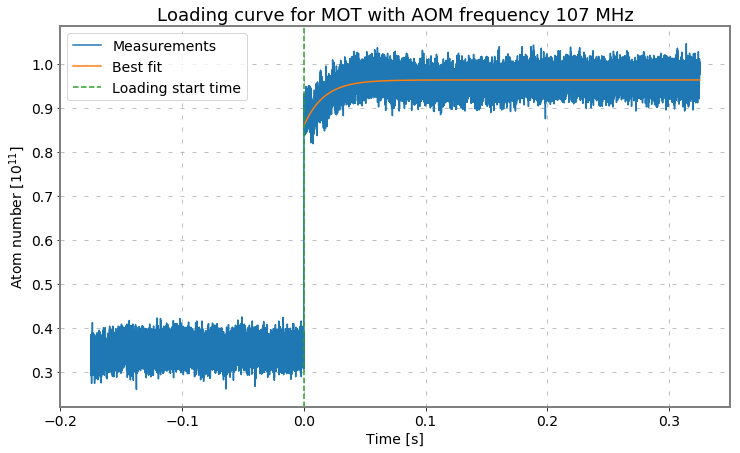

In [22]:
# AOM Frequency 107 MHz
file_107 = 'data/NikolasJohann/AOM_change_107_4.csv'
title_107 = 'Loading curve for MOT with AOM frequency 107 MHz'

popt_107, pcov_107, n_107 = plotter_fitter_happier(file_107, 107, title_107)

plt.savefig('diagrams/LoadingCurve107.png')

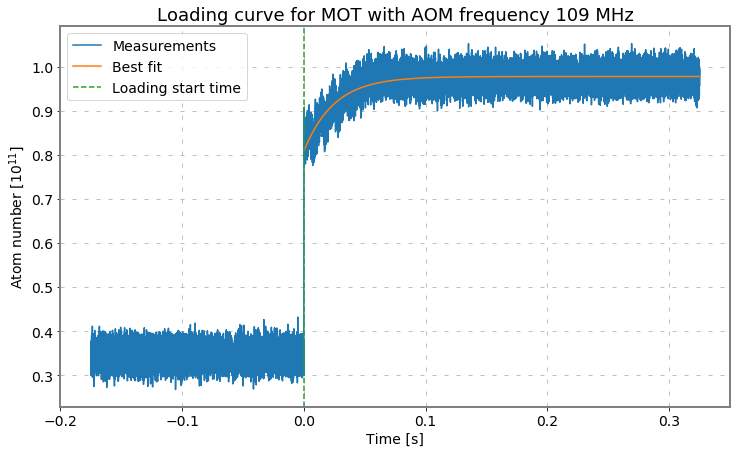

In [23]:
# AOM Frequency 109 MHz
file_109 = 'data/NikolasJohann/AOM_change_109.csv'
title_109 = 'Loading curve for MOT with AOM frequency 109 MHz'

popt_109, pcov_109, n_109 = plotter_fitter_happier(file_109, 109, title_109)

plt.savefig('diagrams/LoadingCurve109.png')

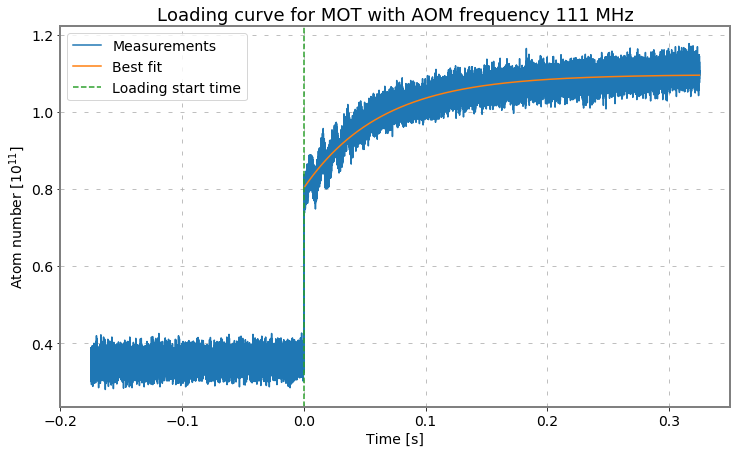

In [24]:
# AOM Frequency 111 MHz
file_111 = 'data/NikolasJohann/AOM_change_111.csv'
title_111 = 'Loading curve for MOT with AOM frequency 111 MHz'

popt_111, pcov_111, n_111 = plotter_fitter_happier(file_111, 111, title_111)

plt.savefig('diagrams/LoadingCurve111.png')

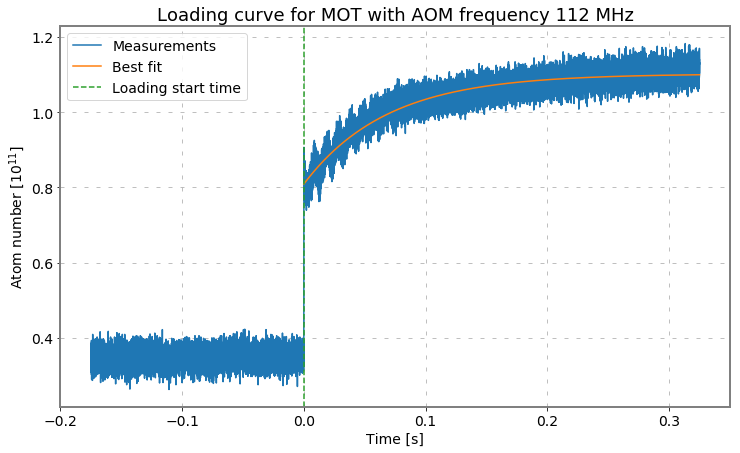

In [25]:
# AOM Frequency 112 MHz
file_112 = 'data/NikolasJohann/AOM_change_112.csv'
title_112 = 'Loading curve for MOT with AOM frequency 112 MHz'

popt_112, pcov_112, n_112 = plotter_fitter_happier(file_112, 112, title_112)

plt.savefig('diagrams/LoadingCurve112.png')

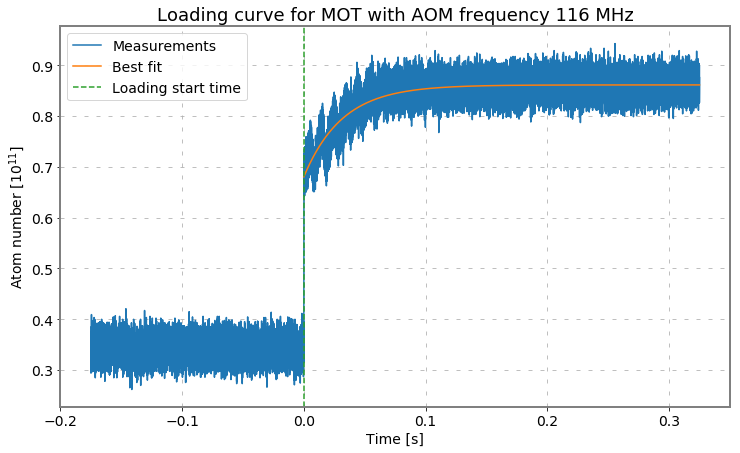

In [26]:
# AOM Frequency 116 MHz
file_116 = 'data/NikolasJohann/AOM_change_116.csv'
title_116 = 'Loading curve for MOT with AOM frequency 116 MHz'

popt_116, pcov_116, n_116 = plotter_fitter_happier(file_116, 116, title_116)

plt.savefig('diagrams/LoadingCurve116.png')

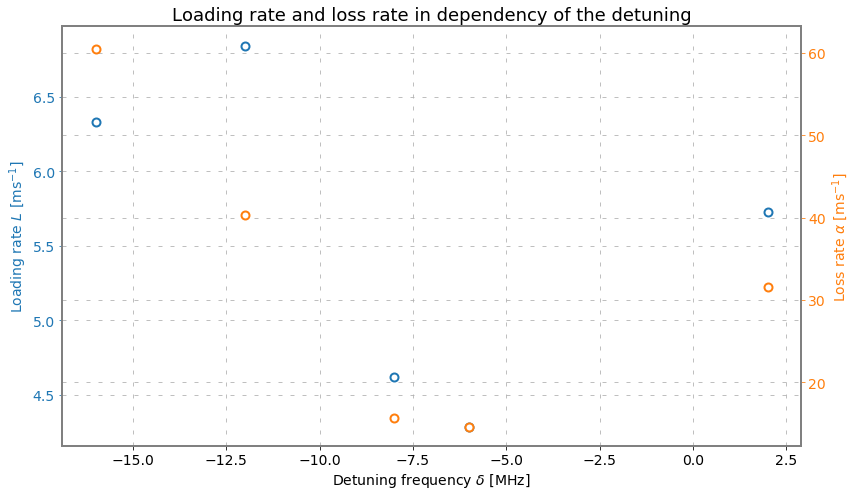

In [27]:
# Detuning
delta_cool = -60 - 2 * 85 + 2 * np.array([107, 109, 111, 112, 116])
Ls = np.array([popt_107[0], popt_109[0], popt_111[0], popt_112[0], 
               popt_116[0]])
err_Ls = np.array([pcov_107[0,0], pcov_109[0,0], pcov_111[0,0], pcov_112[0, 0], 
               pcov_116[0, 0]])
alphas = np.array([popt_107[1], popt_109[1], popt_111[1], popt_112[1], 
               popt_116[1]])
err_alphas = np.array([pcov_107[1,1], pcov_109[1,1], pcov_111[1,1], pcov_112[1,1], 
               pcov_116[1, 1]])
cs = np.array([popt_107[2], popt_109[2], popt_111[2], popt_112[2], 
               popt_116[2]])
ns = np.array([n_107, n_109, n_111, n_112, n_116])

fig, ax1 = plt.subplots()
ax1.set_title('Loading rate and loss rate in dependency of the detuning')

ax1.errorbar(delta_cool, Ls, yerr = err_Ls, color = 'C0', fmt = 'o', 
            mfc = 'w', capsize = 0, markersize = 8, markeredgewidth = 2)
ax1.set_xlabel('Detuning frequency $\\delta$ [MHz]')
ax1.tick_params(axis = 'y', color = 'C0', labelcolor = 'C0')
ax1.set_ylabel('Loading rate $L$ [ms$^{-1}$]', color = 'C0')

ax2 = ax1.twinx()

ax2.set_ylabel('Loss rate $\\alpha$ [ms$^{-1}$]', color = 'C1')
ax2.tick_params(axis = 'y', color = 'C1', labelcolor = 'C1')
ax2.errorbar(delta_cool, alphas, yerr = err_alphas, color = 'C1', fmt ='o',
             mfc = 'w', capsize = 0, markersize = 8, markeredgewidth = 2)

fig.tight_layout()
fig.savefig('diagrams/LoadingRate.png')

We can see a diagram in some ways similar to the one depicted in the script, where we can observe the behavior of the loading rate and find an extremum. In our case, our extremum appears to be a minimum which counters the expectations. 

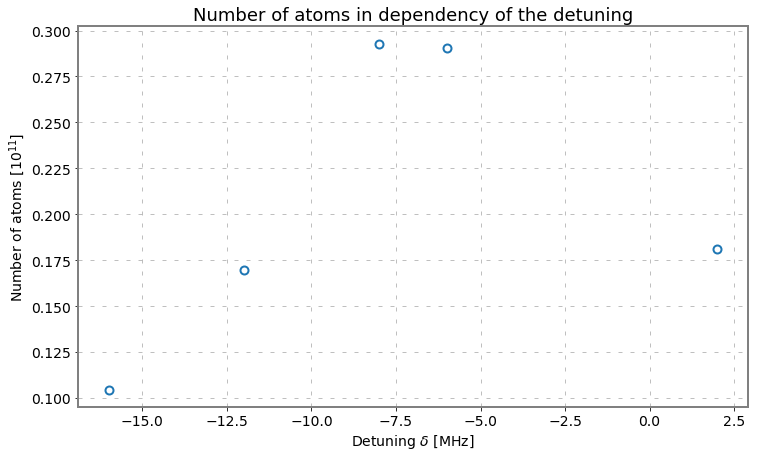

In [28]:
# Number of atoms
plt.title('Number of atoms in dependency of the detuning')
plt.errorbar(delta_cool, ns, fmt ='o',
             mfc = 'w', capsize = 0, markersize = 8, markeredgewidth = 2)
plt.ylabel('Number of atoms [$10^{11}$]')
plt.xlabel('Detuning $\\delta$ [MHz]')

plt.savefig('diagrams/number_atoms.png')

#### 2.2 Loading rate in dependency of the current gradient

Again we run into the problem of working with external data, where the parameters with which the measurements were taken are unknown to us. For the conversion of signal to atom number we require the detuning, which we will assume constant along the following measurements and assign the aom frequency a value of $110\,\mathrm{MHz}$. This would likely be the case, as it was shown to us that this frequency was optimal for the measurements. It would make sense to perform the adjustments around this value.

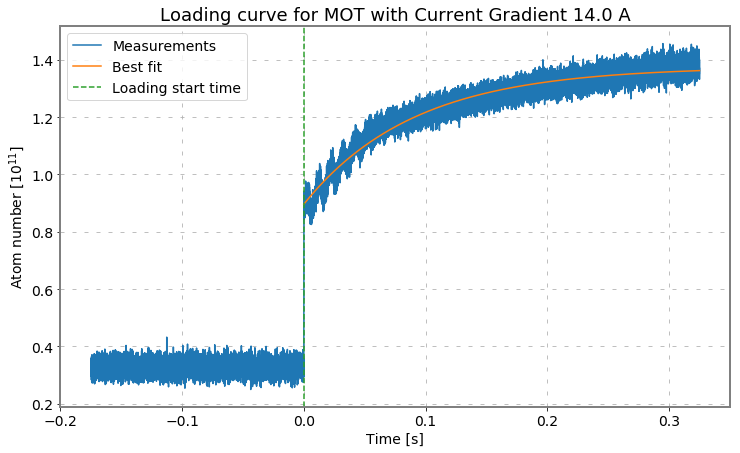

In [29]:
# Current gradient 14 A
file_14_0 = 'data/NikolasJohann/Current_grad_14_0.csv'
title_14_0 = 'Loading curve for MOT with Current Gradient 14.0 A'

popt_14_0, pcov_14_0, n_14_0 = plotter_fitter_happier(file_14_0, 110, title_14_0)

plt.savefig('diagrams/LoadingCurve14_0.png')

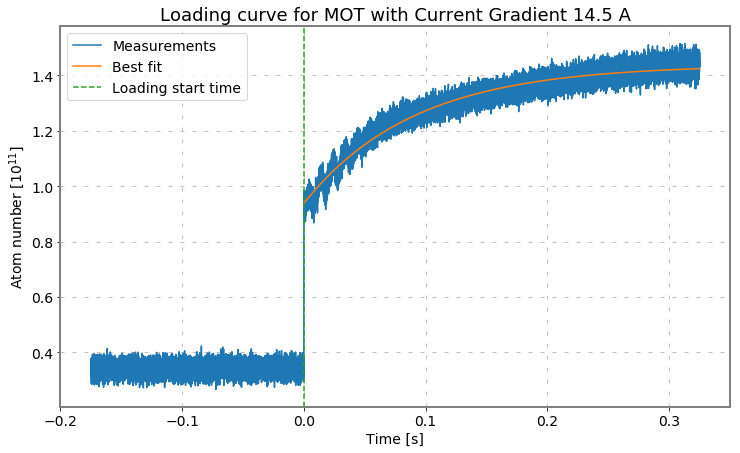

In [30]:
# Current gradient 14.5 A
file_14_5 = 'data/NikolasJohann/Current_grad_14_5.csv'
title_14_5 = 'Loading curve for MOT with Current Gradient 14.5 A'

popt_14_5, pcov_14_5, n_14_5 = plotter_fitter_happier(file_14_5, 112, title_14_5)

plt.savefig('diagrams/LoadingCurve14_5.png')

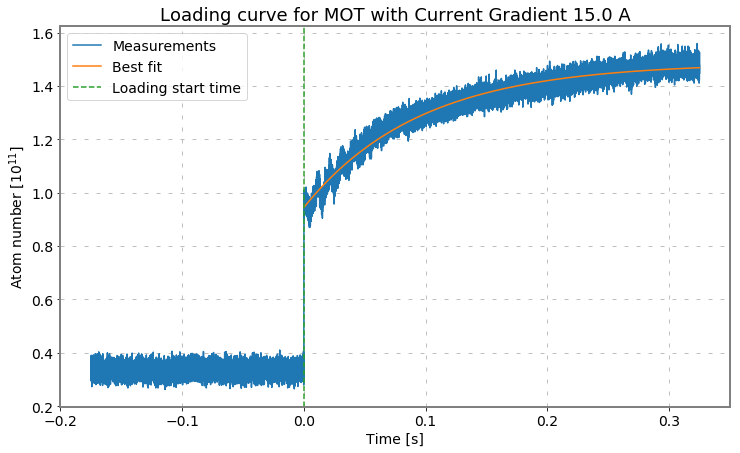

In [31]:
# Current gradient 15 A
file_15_0 = 'data/NikolasJohann/Current_grad_15_0.csv'
title_15_0 = 'Loading curve for MOT with Current Gradient 15.0 A'

popt_15_0, pcov_15_0, n_15_0 = plotter_fitter_happier(file_15_0, 110, title_15_0)

plt.savefig('diagrams/LoadingCurve15_0.png')

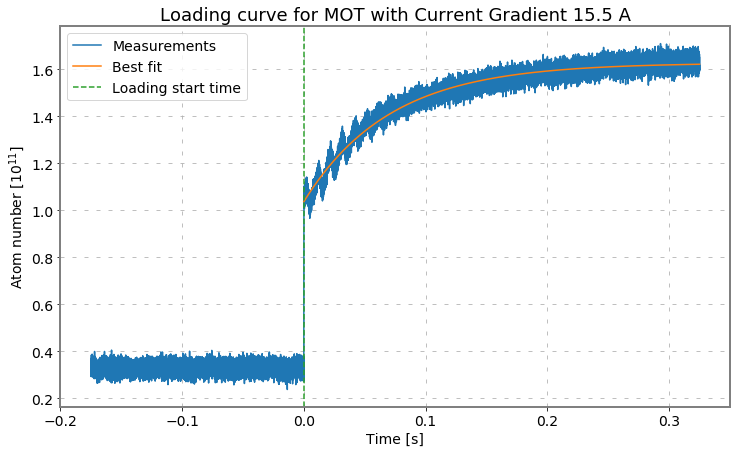

In [32]:
# Current gradient 15.5 A
file_15_5 = 'data/NikolasJohann/Current_grad_15_5.csv'
title_15_5 = 'Loading curve for MOT with Current Gradient 15.5 A'

popt_15_5, pcov_15_5, n_15_5 = plotter_fitter_happier(file_15_5, 110, title_15_5)

plt.savefig('diagrams/LoadingCurve15_5.png')

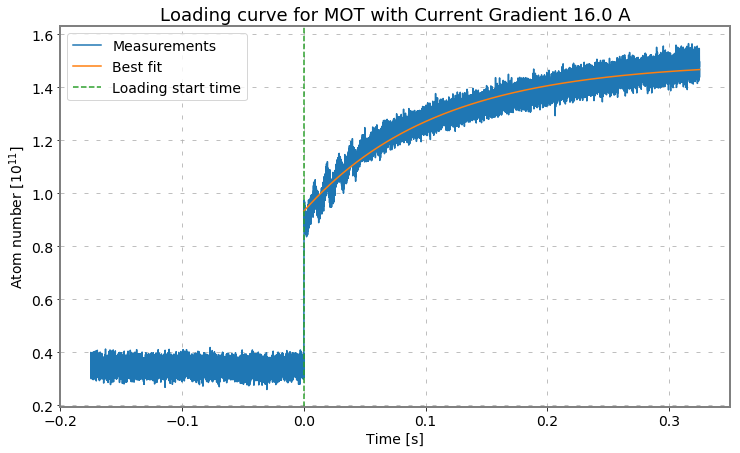

In [33]:
# Current gradient 16 A
file_16_0 = 'data/NikolasJohann/Current_grad_16_0.csv'
title_16_0 = 'Loading curve for MOT with Current Gradient 16.0 A'

popt_16_0, pcov_16_0, n_16_0 = plotter_fitter_happier(file_16_0, 110, title_16_0)

plt.savefig('diagrams/LoadingCurve16_0.png')

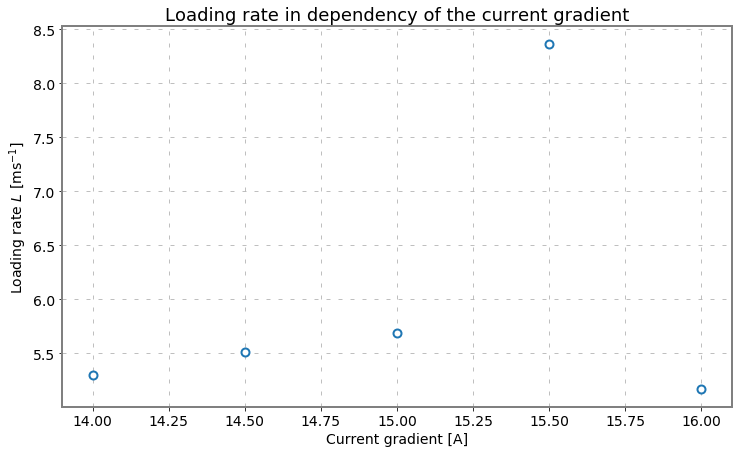

In [34]:
# Current gradient
current_grad = np.array([14, 14.5, 15, 15.5, 16])
Ls_current = np.array([popt_14_0[0], popt_14_5[0], popt_15_0[0], popt_15_5[0], 
               popt_16_0[0]])
err_Ls_current = np.array([pcov_14_0[0, 0], pcov_14_5[0, 0], pcov_15_0[0, 0], 
                           pcov_15_5[0,0], pcov_16_0[0, 0]])

plt.title('Loading rate in dependency of the current gradient')
plt.errorbar(current_grad, Ls_current, yerr = err_Ls_current, fmt ='o',
             mfc = 'w', capsize = 0, markersize = 8, markeredgewidth = 2)
plt.xlabel('Current gradient [A]')
plt.ylabel('Loading rate $L$ [ms$^{-1}$]')

plt.savefig('diagrams/LoadingRate_current.png')

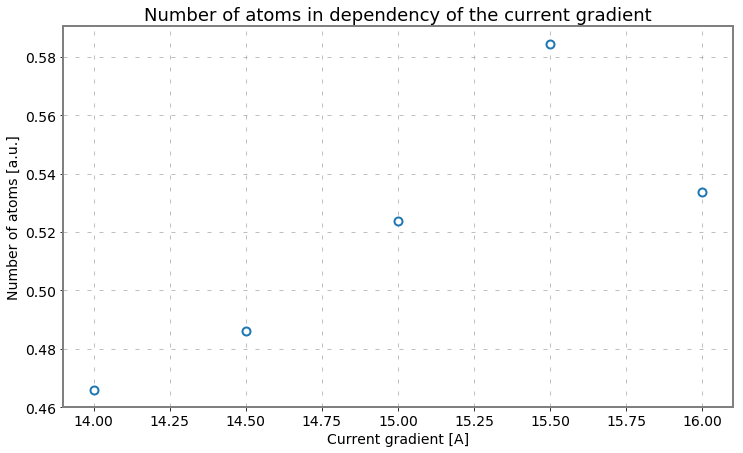

In [35]:
# Number of atoms
ns_current = np.array([n_14_0, n_14_5, n_15_0, n_15_5, n_16_0])
fig, ax = plt.subplots()
ax.title.set_text('Number of atoms in dependency of the current gradient')
ax.errorbar(current_grad, ns_current, fmt ='o',
             mfc = 'w', capsize = 0, markersize = 8, markeredgewidth = 2)
ax.set_ylabel('Number of atoms [a.u.]')
ax.set_xlabel('Current gradient [A]')

fig.savefig('diagrams/number_atoms_current.png')

#### 3. Release and recapture

We have a series of measurements, each with a corresponding background measurement which we want to subtract. The file titling follows a structure which is easy to iterate through with files paired by: "CommonNumber_mit.csv" or CommonNumber_ohne.csv", so we will extract the common numbers and use these to pair corresponding files with each other. 

In [36]:
folder_path = 'data/NikolasJohann/Release_Recapture'
file_pairs = {}

# Iterate through the files in the folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    ''' Check only .csv files, for some reason there's always a ghost
    .ipnyb file in the folder that causes trouble when iterating through it '''
    if filename.endswith('.csv'):
        # Extract the common number from the file name
        common_number = filename.split('_')[0]

        ''' Want to check if a file already has a corresponding entry in the
        dictionary. If not, create one. '''
        if common_number in file_pairs:
            file_pairs[common_number].append(file_path)
        else:
            file_pairs[common_number] = [file_path]
            
for common_number, file_pair in file_pairs.items():
#    print(file_pair)
    for file in file_pair:
        if '_mit' in file:
            file_mit = file
        else:
            file_ohne = file
        

In [37]:
''' Now we want to iterate through our dictionary and perform the background
subtraction for every pair '''
mss = np.array([])
ns_over_n_maxes = np.array([])
std_ns_over_n_maxes = np.array([])



for common_number, files in file_pairs.items():
    mss = np.append(mss, int(common_number))
    for file in files:
#        print(file)
        if 'mit' in file:
            file_mit = file
            data_mit = kindle(file, 110)
        elif 'ohne' in file:
            file_ohne = file
            data_ohne = kindle(file, 110)
            
    # Time separation between each new data point:
    factor = np.abs(data_mit[0][2] - data_mit[0][1]) * 1e3

    # Determine the on and off times first
    a = np.where(data_mit[2] < 0.5 * np.max(data_mit[2]))[0][0]
    b = int(a + int(common_number) / factor)
    
    # Subtract background
    data = data_mit[0], data_mit[1], data_mit[2] - data_ohne[2]

    
    # Mean of maximum region
    n_max_unc, std_n_max_unc = np.mean(data[2][:a]), np.std(data[2][:a])
    # Mean of zero region, for calibration
    n_zero, std_n_zero = np.mean(data[2][a:b]), np.std(data[2][a:b])
    # "Real maximum"
    n_max = n_max_unc - n_zero
    std_n_max = sqrt(std_n_max_unc ** 2 +std_n_zero ** 2)
    # n recaptured
    n = np.mean(data[2][b:b+200]) - n_zero 
    std_n = sqrt(np.std(data[2][b:b+200]) ** 2 + std_n_zero ** 2)
    # Determine N / N_max
    n_over_n_max = n / n_max
    std_n_over_n_max = sqrt( (std_n / n_max) ** 2 
                            + (n / (n_max ** 2) * std_n_max) ** 2 )
    
    ns_over_n_maxes = np.append(ns_over_n_maxes, n_over_n_max)
    std_ns_over_n_maxes = np.append(std_ns_over_n_maxes, std_n_over_n_max)
    # Fit data in appropriate range
    popt, pcov = curve_fit(n_of_t, data[0][b:], data[2][b:]) 



    # Plot
    fig, ax = plt.subplots()
    ax.title.set_text('Release and recapture method for relase time $t = $' 
              + str(common_number) + ' ms')
    ax.plot(data[0], data[2], label = 'Background corrected data')
    ax.axvline(data_mit[0][a], label = 'Loading stop time', ls = '--', 
                color = 'C2')
    ax.axvline(data_mit[0][b], label = 'Reloading start time', ls = '--', 
               color = 'C3')
    
    ax.text(0.5, 0.5, 
            fitparameter('$\dfrac{n_{\mathrm{recap}}}{n_{\mathrm{max}}}$',
                        n_over_n_max, std_n_over_n_max, 2, ''), 
            horizontalalignment='center',
            verticalalignment='center',
            transform = ax.transAxes,
            bbox = props, fontsize = 14)
    ax.set_xlabel('Time [s]')
    ax.set_ylabel('Atom number [$10^{11}$]')
    
    ax.legend(loc = 'best')
    
    fig.savefig('diagrams/release_recapture_ms_' + str(common_number) + '.png')
    plt.close(fig)
    

In [38]:
# [Bin 1]

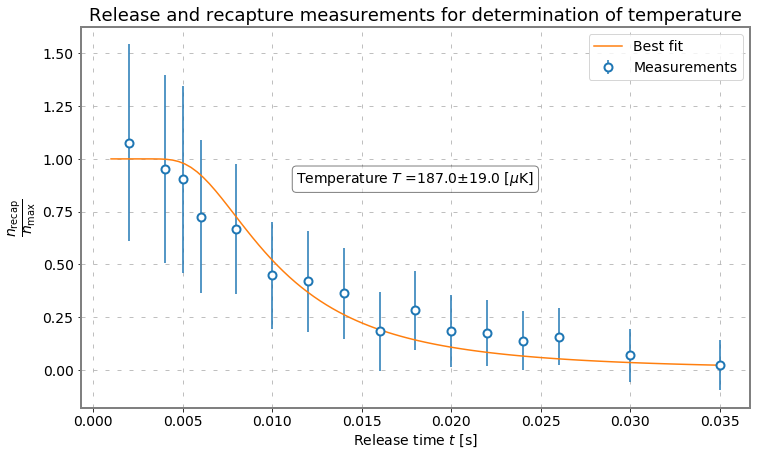

In [39]:
# Fit
def n_over_n_max_of_t(t, T):
    R = 1.5 * 1e-3 # m
    kB = 1.380649 * 1e-23 # m^2 kg s^-2 K^-1
    u = 1.660 * 1e-27 # kg
    M = 85.47 * u
    
    return (erf( sqrt(M / (kB * T)) * R / (t) ) - 2 / sqrt(pi) 
            * sqrt(M / (kB * T)) * R / (t)  
            * exp( - (sqrt(M / (kB * T)) * R / (t)) ** 2 ))


popt_rr, pcov_rr = curve_fit(n_over_n_max_of_t, mss * 1e-3, ns_over_n_maxes, 
                             p0 = 150 * 1e-6)
T = popt_rr[0] * 1e6 # muK
err_T = sqrt(pcov_rr[0][0]) * 1e6


# Plot for temperature
fig, ax = plt.subplots()
title = 'Release and recapture measurements for determination of temperature'
ax.title.set_text(title)
ax.errorbar(mss * 1e-3, ns_over_n_maxes, yerr = std_ns_over_n_maxes, fmt ='o', 
            mfc = 'w', capsize = 0, markersize = 8, markeredgewidth = 2, 
            label = 'Measurements')

t_lin = np.linspace(1 * 1e-3, 35 * 1e-3, 100)
ax.plot(t_lin, n_over_n_max_of_t(t_lin, popt_rr), label = 'Best fit')

ax.text(0.5, 0.6, 
        fitparameter('Temperature $T$',
                    T, err_T, 0, ' [$\mu$K]'), 
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax.transAxes,
        bbox = props, fontsize = 14)

ax.set_ylabel('$\dfrac{n_{\mathrm{recap}}}{n_{\mathrm{max}}}$')
ax.set_xlabel('Release time $t$ [s]')
ax.legend(loc = 'best')
fig.savefig('diagrams/ReleaseRecaptureTemperature.png')

To contextualize this result, the determined temperature of the MOT is slightly higher than the Doppler temperature ($T_D = 145.57\, \mu \mathrm{K}$). This means that the fit corresponds to realistic expectations.